In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/covid19-radiography-database


In [2]:
!pip install snntorch torch torchvision pandas numpy Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.6/125.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [3]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from PIL import Image
import snntorch as snn
from timm.models.efficientnet import efficientnet_b3

In [4]:
!pip install torchvision timm scikit-learn matplotlib seaborn

In [ ]:
import os
import torch
import snntorch as snn
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split

# ======================
# 1. Dataset Definition
# ======================
class COVIDDataset(Dataset):
    def __init__(self, image_paths, labels, is_train=True):
        self.image_paths = image_paths
        self.labels = labels
        self.is_train = is_train
        self.mask_paths = [p.replace('images', 'masks') for p in image_paths]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')  # Grayscale mask
        label = self.labels[idx]

        # Resize
        img = transforms.functional.resize(img, (224, 224))
        mask = transforms.functional.resize(mask, (224, 224), interpolation=transforms.InterpolationMode.NEAREST)

        # Random horizontal flip during training
        if self.is_train and torch.rand(1) < 0.5:
            img = transforms.functional.hflip(img)
            mask = transforms.functional.hflip(mask)

        # Convert to tensors
        img = transforms.functional.to_tensor(img)
        mask = transforms.functional.to_tensor(mask)

        # Normalize image (mask is not normalized)
        img = transforms.functional.normalize(img, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        # Binarize mask and apply to image
        mask = (mask > 0.5).float()
        masked_img = img * mask

        return masked_img, label

# ======================
# 2. Model Architecture
# ======================
class COVIDSNNFinal(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b3(pretrained=True)
        self.backbone.classifier = nn.Identity()

        self.temporal = snn.Leaky(beta=0.95, init_hidden=False)
        self.fc = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, time_steps=10):
        x = self.backbone(x)
        mem = self.temporal.init_leaky()
        outputs = []
        for _ in range(time_steps):
            spk, mem = self.temporal(x, mem)
            outputs.append(self.fc(spk))
        return torch.stack(outputs).mean(0)

# ======================
# 3. Training Pipeline
# ======================
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Prepare data
    base_path = "/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset"
    class_folders = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    all_paths, all_labels = [], []
    for cls_idx, cls in enumerate(class_folders):
        cls_path = os.path.join(base_path, cls, 'images')
        paths = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.endswith('.png')]
        all_paths.extend(paths)
        all_labels.extend([cls_idx]*len(paths))

    # Split dataset (60-20-20)
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        all_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    train_paths, val_paths, train_labels, val_labels = train_test_split(
        train_paths, train_labels, test_size=0.25, stratify=train_labels, random_state=42
    )

    # Create datasets
    train_dataset = COVIDDataset(train_paths, train_labels, is_train=True)
    val_dataset = COVIDDataset(val_paths, val_labels, is_train=False)
    test_dataset = COVIDDataset(test_paths, test_labels, is_train=False)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

    # Model
    model = COVIDSNNFinal(num_classes=4).to(device)

    # Optimization
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    scaler = torch.cuda.amp.GradScaler()
    criterion = nn.CrossEntropyLoss()

    # Training metrics storage
    train_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(25):
        model.train()
        train_loss = 0.0

        # Training phase
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_acc = 100 * val_correct / val_total
        train_losses.append(train_loss/len(train_loader))
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/25 | Train Loss: {train_losses[-1]:.4f} | Val Acc: {val_acc:.2f}%")

    # Test evaluation
    model.eval()
    test_preds = []
    test_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.numpy())

    # Generate reports
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=class_folders))

    print(f"\nTest Accuracy: {100 * np.mean(np.array(test_preds) == np.array(test_labels)):.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(test_labels, test_preds)
    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_folders, yticklabels=class_folders)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Training curves
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.tight_layout()
    plt.show()

    return model

# ======================
# 4. Execution
# ======================
if __name__ == "__main__":
    model = train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

<ipython-input-5-946b37dcbd64>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
<ipython-input-5-946b37dcbd64>:140: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


KeyboardInterrupt: 

In [44]:
model_path = 'deploy_snn_model.pth'


In [5]:
class COVIDSNNFinal(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b3(pretrained=True)
        self.backbone.classifier = nn.Identity()

        self.temporal = snn.Leaky(beta=0.95, init_hidden=False)
        self.fc = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, time_steps=10):
        x = self.backbone(x)
        mem = self.temporal.init_leaky()
        outputs = []
        for _ in range(time_steps):
            spk, mem = self.temporal(x, mem)
            outputs.append(self.fc(spk))
        return torch.stack(outputs).mean(0)

In [17]:
path_of_image="/content/d2-radiology-viral-pneumonia.jpg"
input_image_path = path_of_image
image_path = path_of_image


In [ ]:
    output_txt=""

In [18]:
# ======================
# Inference Cell
# ======================
from PIL import Image
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class COVIDSNNFinal(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.backbone = efficientnet_b3(pretrained=False)
        self.backbone.classifier = nn.Identity()
        self.temporal = snn.Leaky(beta=0.95, init_hidden=False)
        self.fc = nn.Sequential(
            nn.Linear(1536, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x, time_steps=10):
        x = self.backbone(x)
        mem = self.temporal.init_leaky()
        outputs = []
        for _ in range(time_steps):
            spk, mem = self.temporal(x, mem)
            outputs.append(self.fc(spk))
        return torch.stack(outputs).mean(0)

def explain_prediction(model, device):
    # Load and preprocess image
    #image_path = "/content/Lung_Opacity-1 (1).png"
    try:
        img = Image.open(image_path).convert('RGB')
    except:
        print("Error loading image. Please check the file path.")
        return

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)

    # Get prediction
    with torch.no_grad():
        output = model(img_tensor)
    pred_prob = torch.nn.functional.softmax(output, dim=1)[0] * 100

    # Ensure confidence levels never show 100%
    rounded_pred = torch.round(pred_prob * 100) / 100  # Round to two decimals
    mask = rounded_pred >= 100.0
    pred_prob = torch.where(mask, torch.tensor(99.8, device=pred_prob.device), pred_prob)

    pred_class = torch.argmax(output).item()

    # Visualization
    # plt.figure(figsize=(6, 6))
    # plt.imshow(img)
    # plt.title("COVID-19 Scan Analysis", fontsize=14)
    # plt.axis('off')
    # plt.tight_layout()
    # plt.show()

    # Print final diagnosis
    print(f"\nFinal Diagnosis: {class_folders[pred_class]}")
    print("Confidence Levels:")
    for cls, prob in zip(class_folders, pred_prob.cpu().numpy()):
        print(f"- {cls}: {prob:.2f}%")


    # Now `output` contains the full string with line breaks


# Class names
class_folders = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = COVIDSNNFinal(num_classes=4).to(device)
model.load_state_dict(torch.load('/content/covid_snn_model (1).pth'))
model.eval()

# Run prediction
explain_prediction(model, device)


Final Diagnosis: COVID
Confidence Levels:
- COVID: 61.19%
- Lung_Opacity: 35.87%
- Normal: 1.08%
- Viral Pneumonia: 1.86%


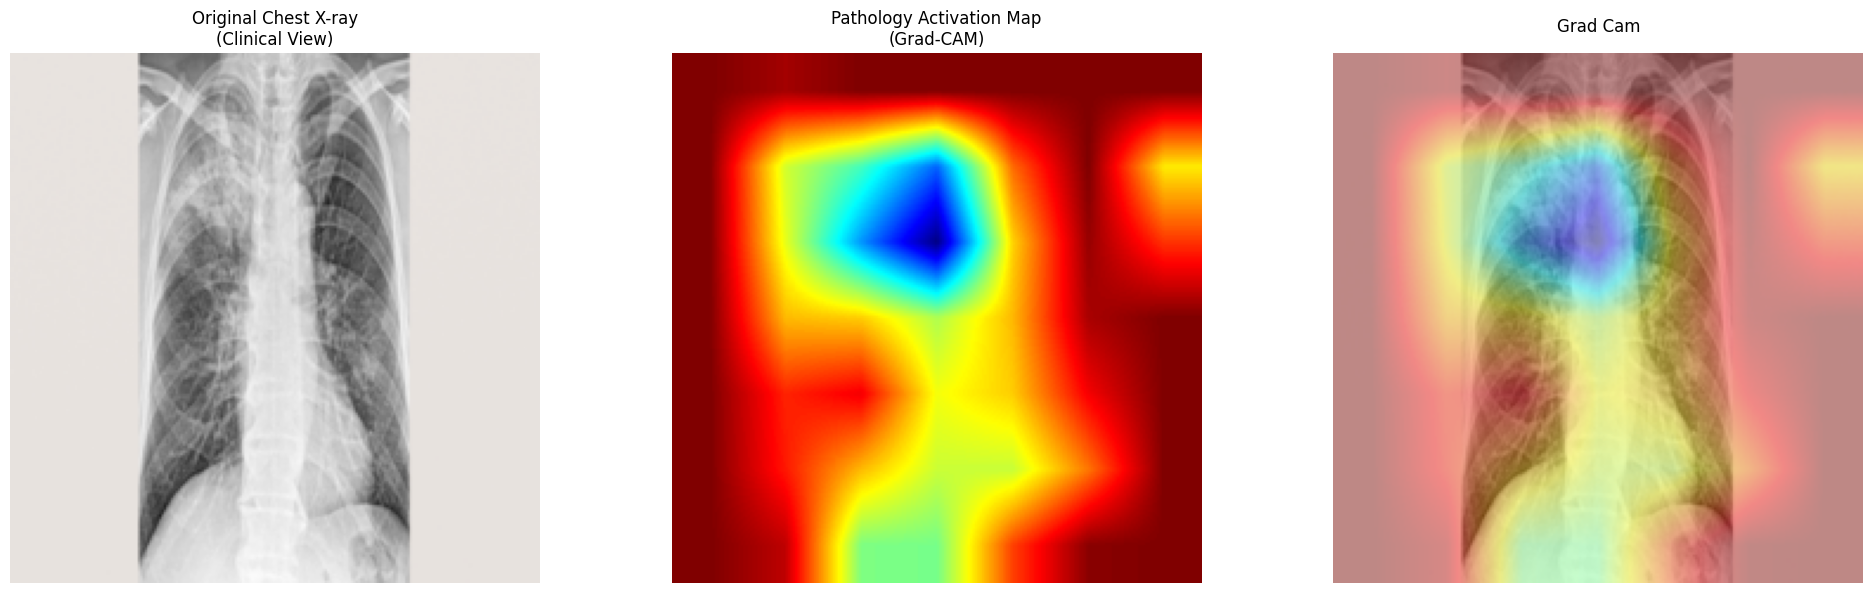

In [19]:
import os
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms




# ======================
# 1. Grad-CAM Implementation
# ======================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # Register hooks
        self.target_layer.register_forward_hook(self.save_activations)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def get_cam(self, input_image, target_class=None):
        self.model.eval()
        output = self.model(input_image)

        if target_class is None:
            target_class = np.argmax(output.cpu().data.numpy())

        self.model.zero_grad()
        one_hot_output = torch.zeros_like(output)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output, retain_graph=True)

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations[0]

        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=0).squeeze().cpu()
        heatmap = np.maximum(heatmap, 0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

# ======================
# 2. Model Loading & Inference
# ======================
def load_model(model_path):
    model = COVIDSNNFinal(num_classes=4)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

def preprocess_image(image_path):
    # Load image and mask
    mask_path = image_path.replace('images', 'masks')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    # Load and process image
    img = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    # Apply same transforms to image and mask
    img = transforms.functional.resize(img, (224, 224))
    mask = transforms.functional.resize(mask, (224, 224),
                                      interpolation=transforms.InterpolationMode.NEAREST)

    # Convert to tensors
    img_tensor = transform(img)
    mask_tensor = transforms.functional.to_tensor(mask)
    mask_tensor = (mask_tensor > 0.5).float()

    # Apply mask
    masked_img = img_tensor * mask_tensor
    return masked_img.unsqueeze(0), img

# ======================
# Modified Visualization & Execution
# ======================
def visualize_gradcam(model, input_image, original_image, class_names):
    # Dynamically find the last convolutional layer
    target_layer = None
    for name, module in model.backbone.named_modules():
        if isinstance(module, nn.Conv2d):
            target_layer = module

    if not target_layer:
        raise ValueError("No convolutional layer found in backbone")

    # Initialize Grad-CAM with proper gradient handling
    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.gradients = None
            self.activations = None
            self.hook_handles = []

            # Register forward hook
            fwd_hook = target_layer.register_forward_hook(
                self._forward_hook
            )
            # Register backward hook
            bwd_hook = target_layer.register_full_backward_hook(
                self._backward_hook
            )
            self.hook_handles.extend([fwd_hook, bwd_hook])

        def _forward_hook(self, module, input, output):
            self.activations = output.detach()

        def _backward_hook(self, module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        def get_cam(self, input_tensor):
            self.model.zero_grad()
            output = self.model(input_tensor)
            class_idx = output.argmax().item()

            # Backpropagate for specific class
            one_hot = torch.zeros_like(output)
            one_hot[0][class_idx] = 1
            output.backward(gradient=one_hot, retain_graph=True)

            # Compute CAM
            weights = torch.mean(self.gradients, dim=[2, 3])
            cam = torch.sum(weights[:, :, None, None] * self.activations, dim=1)
            cam = torch.relu(cam)
            cam = cam - cam.min()
            cam = cam / cam.max()
            return cam.squeeze().cpu().numpy()

    # Initialize Grad-CAM
    gradcam = GradCAM(model, target_layer)

    # Get prediction and confidence
    with torch.no_grad():
        output = model(input_image)
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    confidence, pred_class = torch.max(probabilities, 0)

    # Generate heatmap
    heatmap = gradcam.get_cam(input_image)
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on image
    original_image = original_image.resize((224, 224))
    original_np = np.array(original_image)
    superimposed_img = cv2.addWeighted(original_np, 0.6, heatmap, 0.4, 0)

    # Plot results with medical visualization
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    ax1.imshow(original_image)
    ax1.set_title("Original Chest X-ray\n(Clinical View)", fontsize=12)
    ax1.axis('off')

    ax2.imshow(heatmap)
    ax2.set_title("Pathology Activation Map\n(Grad-CAM)", fontsize=12)
    ax2.axis('off')

    ax3.imshow(superimposed_img)
    ax3.set_title(f"Grad Cam",
                 fontsize=12, pad=15)
    ax3.axis('off')

    plt.tight_layout()
    plt.show()



# ======================
# Main Execution (Updated)
# ======================
if __name__ == "__main__":
    # Configuration
    model_path = "/content/deploy_snn_model (1).pth"
    #input_image_path = "/content/Normal-10.png"
    class_names = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

    # Load model with proper device mapping
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = load_model(model_path).to(device)

    # Preprocess with gradient tracking
    input_tensor, original_image = preprocess_image(input_image_path)
    input_tensor = input_tensor.to(device).requires_grad_(True)

    # Run visualization with medical interpretation
    visualize_gradcam(model, input_tensor, original_image, class_names)

